In [1]:
import datetime
import json
import os
import pandas as pd
import geopy.distance
import itertools
import copy
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import io

In [2]:
# Not needed if not in Google Colab
# This will prompt to import CSV's. All CSV's in file path can be uploaded.
#from google.colab import files
#uploaded = files.upload()

In [ ]:
def percentile_normalize_scale(weight_list):
    clean_list = []
    for value in weight_list:
        if value != None:
            clean_list.append(value)

    q1, q3 = np.percentile(clean_list, [25,75])
    iqr = q3 - q1
    median = np.median(clean_list)
    weights_no_outliers = []
    for i in clean_list:
        if i < median - 1.5*iqr or i > median + 1.5*iqr:
            pass
        else:
            weights_no_outliers.append(i)
    min_value = np.min(weights_no_outliers)
    max_value = np.max(weights_no_outliers)
    return min_value, max_value

In [ ]:
def apply_scale(value, min_value, max_value):
    if value == None:
        v = 1
    else:
        v = (value - min_value) / (max_value-min_value)
    return v

In [ ]:
def generate_single_day_graphs(date):
    df_attributes = pd.read_csv(f'df_attributes_{date}.csv')
    df_store_cust_dist_calc = pd.read_csv(f'df_store_cust_dist_calc_{date}.csv')
    df_parent_cust_dist_calc = pd.read_csv(f'df_parent_cust_dist_calc_{date}.csv')

    store_as = np.unique(np.array(df_store_cust_dist_calc['store_a']))
    cust_bs = np.unique(np.array(df_store_cust_dist_calc['cust_b']))

    G_store_cust_more_weights = nx.MultiDiGraph()
    G_store_cust_more_weights.add_nodes_from(store_as, type='store')
    G_store_cust_more_weights.add_nodes_from(cust_bs, type='customer')
    for a in store_as:
        for b in cust_bs:
            if a != b:
                edge = df_store_cust_dist_calc[(df_store_cust_dist_calc['store_a']==a) &
                                           (df_store_cust_dist_calc['cust_b']==b)]['store_cust_dist'].values[0]
                #try:
                #    eligible = df_attributes[df_attributes["CUSTOMER_ADDRESS_ID"]==b]["PERCENT_OF_ORDER_ELIGIBLE"].values[0]
                #    eligible = 1 - float(eligible)
                #except:
                #    eligible = 1
                eligible = 0
                try:
                    cost_savings = df_attributes[df_attributes["CUSTOMER_ADDRESS_ID"]==b]["COST_SAVINGS_PERCENT"].values[0]
                    cost_savings = float(cost_savings)
                except:
                    cost_savings = 1
                try:
                    price_savings = df_attributes[df_attributes["CUSTOMER_ADDRESS_ID"]==b]["PRICE_SAVINGS_PERCENT"].values[0]
                    price_savings = float(price_savings)
                except:
                    price_savings = 1
                try:
                    a_cost = df_attributes[df_attributes["CUSTOMER_ADDRESS_ID"]==b]["COMPARABLE_ACTUAL_TOTAL_COST_"].values[0]
                    a_cost = float(a_cost)
                except:
                    a_cost = None
                try:
                    p_cost = df_attributes[df_attributes["CUSTOMER_ADDRESS_ID"]==b]["PARENT_TOTAL_COST_"].values[0]
                    p_cost = float(p_cost)
                except:
                    p_cost = None
                try:
                    a_price = df_attributes[df_attributes["CUSTOMER_ADDRESS_ID"]==b]["COMPARABLE_ACTUAL_TOTAL_PRICE_"].values[0]
                    a_price = float(a_price)
                except:
                    a_price = None
                try:
                    p_price = df_attributes[df_attributes["CUSTOMER_ADDRESS_ID"]==b]["PARENT_TOTAL_PRICE_"].values[0]
                    p_price = float(p_price)
                except:
                    p_price = None
                attr = OrderedDict([("miles",edge),
                    ("eligible",0),
                    ("cost_save_percent",cost_savings),
                    ("price_save_percent",price_savings),
                    ("actual_cost",a_cost),
                    ("parent_cost",p_cost),
                    ("actual_price",a_price),
                    ("parent_price",p_price)])
                G_store_cust_more_weights.add_edge(a,b,**attr)
                G_store_cust_more_weights.add_edge(b,a,**attr)

    store_as = np.unique(np.array(df_parent_cust_dist_calc['parent_a']))
    cust_bs = np.unique(np.array(df_parent_cust_dist_calc['cust_b']))

    G_parent_cust_more_weights = nx.MultiDiGraph()
    G_parent_cust_more_weights.add_nodes_from(store_as, type='store')
    G_parent_cust_more_weights.add_nodes_from(cust_bs, type='customer')
    for a in store_as:
        for b in cust_bs:
            if a != b:
                edge = df_parent_cust_dist_calc[(df_parent_cust_dist_calc['parent_a']==a) &
                                           (df_parent_cust_dist_calc['cust_b']==b)]['parent_cust_dist'].values[0]
                try:
                    eligible = df_attributes[df_attributes["CUSTOMER_ADDRESS_ID"]==b]["PERCENT_OF_ORDER_ELIGIBLE"].values[0]
                    eligible = 1 - float(eligible)
                except:
                    eligible = 1
                try:
                    cost_savings = df_attributes[df_attributes["CUSTOMER_ADDRESS_ID"]==b]["COST_SAVINGS_PERCENT"].values[0]
                    cost_savings = float(cost_savings)
                except:
                    cost_savings = 1
                try:
                    price_savings = df_attributes[df_attributes["CUSTOMER_ADDRESS_ID"]==b]["PRICE_SAVINGS_PERCENT"].values[0]
                    price_savings = float(price_savings)
                except:
                    price_savings = 1
                try:
                    a_cost = df_attributes[df_attributes["CUSTOMER_ADDRESS_ID"]==b]["COMPARABLE_ACTUAL_TOTAL_COST_"].values[0]
                    a_cost = float(a_cost)
                except:
                    a_cost = None
                try:
                    p_cost = df_attributes[df_attributes["CUSTOMER_ADDRESS_ID"]==b]["PARENT_TOTAL_COST_"].values[0]
                    p_cost = float(p_cost)
                except:
                    p_cost = None
                try:
                    a_price = df_attributes[df_attributes["CUSTOMER_ADDRESS_ID"]==b]["COMPARABLE_ACTUAL_TOTAL_PRICE_"].values[0]
                    a_price = float(a_price)
                except:
                    a_price = None
                try:
                    p_price = df_attributes[df_attributes["CUSTOMER_ADDRESS_ID"]==b]["PARENT_TOTAL_PRICE_"].values[0]
                    p_price = float(p_price)
                except:
                    p_price = None
                attr = OrderedDict([("miles",edge),
                    ("eligible",eligible),
                    ("cost_save_percent",cost_savings),
                    ("price_save_percent",price_savings),
                    ("actual_cost",a_cost),
                    ("parent_cost",p_cost),
                    ("actual_price",a_price),
                    ("parent_price",p_price)])
                G_parent_cust_more_weights.add_edge(a,b,**attr)
                G_parent_cust_more_weights.add_edge(b,a,**attr)

    return G_store_cust_more_weights, G_parent_cust_more_weights

In [ ]:
def get_loc_prior_frequencies(i):
    df_store_yesterday_frequency.to_csv(f'df_store_yesterday_frequency_{i}.csv')
    df_parent_yesterday_frequency.to_csv(f'df_parent_yesterday_frequency_{i}.csv')
    return df_store_yesterday_frequency, df_parent_yesterday_frequency

In [ ]:
def get_cust_nodes_set(node_list, graph):
    cust_nodes_check = [i for i in node_list if graph.nodes(data=True)[i]['type']=='customer']
    return set(cust_nodes_check)

### Manual Simulated Annealing Customers Nodes Only Visited Once, Store >= 0
### And Stores Appear in Random.Choice() Selection based on number of
### Prior day's orders

In [ ]:
def weight_dist_func(weight_list,weight_type):
    s = [5 * round(x/5) for x in weight_list]
    ss = [[x,s.count(x)] for x in s]
    xdf = pd.DataFrame(ss,columns=['weight','visits'])
    xdf.drop_duplicates(inplace=True)

    aggdf = xdf.groupby(by=["weight"],as_index=False).sum()
    #plt.bar(aggdf["visits"], aggdf["node_count"])
    aggdf.loc['Grand Total'] = aggdf.sum()
    print(weight_type)
    return display(aggdf)

### Now including 3 different weights for total weight calc.

In [ ]:
import random
import math
import copy as copy_module
def cust_once_simulated_annealing_freq(graph,
                                       initial_temp=100,
                                       cooling_rate=0.01,
                                       data_type='parent'):

    constant_temp = copy_module.copy(initial_temp)
    cust_nodes = [node[0] for node in graph.nodes(data=True)\
                 if graph.degree(node[0]) > 0 and node[1]['type']=='customer']  # get cust nodes
    store_nodes = [node[0] for node in graph.nodes(data=True)\
                 if graph.degree(node[0]) > 0 and node[1]['type']=='store']  # get store nodes
    min_weight, max_weight = percentile_normalize_scale([i[2]['miles'] for i in graph.edges(data=True)])
    min_elg, max_elg = percentile_normalize_scale([i[2]['eligible'] for i in graph.edges(data=True)])
    min_cost=0
    max_cost=0
    min_price=0
    max_price=0
    if data_type=='parent':
        min_cost, max_cost = percentile_normalize_scale([i[2]['parent_cost'] for i in graph.edges(data=True)])
        min_price, max_price = percentile_normalize_scale([i[2]['parent_price'] for i in graph.edges(data=True)])
    else:
        min_cost, max_cost = percentile_normalize_scale([i[2]['actual_cost'] for i in graph.edges(data=True)])
        min_price, max_price = percentile_normalize_scale([i[2]['actual_price'] for i in graph.edges(data=True)])

    store_frequencies = []

    for i in store_nodes:
        store_frequencies.append(1)
    if data_type=='parent':
        for i in store_nodes:
            if i in list(df_parent_yesterday_frequency['PARENT_LOCATION_ID']):
                fc = df_parent_yesterday_frequency[df_parent_yesterday_frequency['PARENT_LOCATION_ID']==i]
                frequency = fc['NUM_ORDERS'].values[0]-1
                store_frequencies[store_nodes.index(i)] = store_frequencies[store_nodes.index(i)]+frequency
    else:
        for i in store_nodes:
            if i in list(df_store_yesterday_frequency['STORE_LOCATION_ID']):
                fc = df_store_yesterday_frequency[df_store_yesterday_frequency['STORE_LOCATION_ID']==i]
                frequency = fc['NUM_ORDERS'].values[0]-1
                store_frequencies[store_nodes.index(i)] = store_frequencies[store_nodes.index(i)]+frequency

    # define a function to generate a random feasible solution
    def generate_sudo_random_solution():
        random_sol = []
        i = 0
        random_sol.append(random.choices(store_nodes,
                                         weights=store_frequencies)[0])
        while len(get_cust_nodes_set(random_sol,graph)) < len(cust_nodes):
            if len(random_sol)%2==0:
                random_sol.append(random.choices(store_nodes,
                                         weights=store_frequencies)[0])
            else:
                c = random.choice(cust_nodes)
                if c not in random_sol:
                    random_sol.append(c)

        return random_sol

    # define the cost function
    def cost_function(solution):
        total_weight = 0
        for i in range(len(solution) - 1):
            if graph.has_edge(solution[i], solution[i+1]):
                if data_type=='parent':
                    w = apply_scale(graph[solution[i]][solution[i+1]][0]['miles'],
                                            min_weight,max_weight)
                    e = apply_scale(graph[solution[i]][solution[i+1]][0]['eligible'], #not used
                                            min_elg,max_elg)
                    c = apply_scale(graph[solution[i]][solution[i+1]][0]['parent_cost'],
                                            min_cost,max_cost)
                    p = apply_scale(graph[solution[i]][solution[i+1]][0]['parent_price'],
                                            min_price,max_price)
                    total_weight += w + c + p
                else:
                    w = apply_scale(graph[solution[i]][solution[i+1]][0]['miles'],
                                            min_weight,max_weight)
                    e = apply_scale(graph[solution[i]][solution[i+1]][0]['eligible'], #not used
                                            min_elg,max_elg)
                    c = apply_scale(graph[solution[i]][solution[i+1]][0]['actual_cost'],
                                            min_cost,max_cost)
                    p = apply_scale(graph[solution[i]][solution[i+1]][0]['actual_price'],
                                            min_price,max_price)
                    total_weight += w + c + p


        return total_weight

    # function to return list of weights in order
    def cost_function_list(solution):
        total_weight_list = []
        for i in range(len(solution) - 1):
            if graph.has_edge(solution[i], solution[i+1]):
                w = graph[solution[i]][solution[i+1]][0]['miles']
                e = graph[solution[i]][solution[i+1]][0]['eligible']
                c = graph[solution[i]][solution[i+1]][0]['cost_save_percent']
                p = graph[solution[i]][solution[i+1]][0]['price_save_percent']

                ac = graph[solution[i]][solution[i+1]][0]['actual_cost']
                tc = graph[solution[i]][solution[i+1]][0]['parent_cost']
                ap = graph[solution[i]][solution[i+1]][0]['actual_price']
                tp = graph[solution[i]][solution[i+1]][0]['parent_price']

                total_weight_list.append([w,e,c,p,ac,tc,ap,tp])
        return total_weight_list

    # set the initial solution to a random feasible solution
    current_solution = generate_sudo_random_solution()
    best_solution = current_solution

    # define the main loop
    k=0
    while initial_temp > 1e-8:
        # generate a new solution by swapping two nodes

        new_solution = current_solution.copy()
        node_switch=1
        while node_switch > 0:
            node1 = random.choice(new_solution)
            node2 = random.choice(new_solution)

            if graph.nodes(data=True)[node1]['type'] == graph.nodes(data=True)[node2]['type']:
                node_switch -=1
                index1 = new_solution.index(node1)
                index2 = new_solution.index(node2)
                new_solution[index1] = node2
                new_solution[index2] = node1

        # calculate the cost difference between the new and current solutions
        delta_cost = cost_function(new_solution) - cost_function(current_solution)

        # if the new solution is better, accept it as the current solution
        if delta_cost < 0:
            current_solution = new_solution
            if cost_function(current_solution) < cost_function(best_solution):
                best_solution = current_solution
        # if the new solution is worse, accept it with a probability based on the temperature
        else:
            prob = math.exp(-constant_temp*delta_cost/initial_temp)
            if random.random() < prob:
                current_solution = new_solution

        # reduce the temperature
        initial_temp *= 1 - cooling_rate
        k += 1
        if k%10==0:
            print(initial_temp, end="\r")
    return best_solution, cost_function(best_solution), cost_function_list(best_solution)

### Generating Results for Multiple Days for Parent Company

In [ ]:
attributes_list = ["score","miles_avg","eligible_avg","cost_savings_perc_avg","price_savings_perc_avg",
                   "actual_cost_avg","parent_cost_avg","actual_price_avg", "parent_price_avg"]
attributes_list_total = ["miles_total",
                       "actual_cost_total","parent_cost_total","actual_price_total", "parent_price_total"]

#date_list = [x.strftime('%Y-%m-%d') for x in pd.date_range('2022-09-01','2022-09-02')]
#df = get_larger_data_set('2022-06-01','2022-12-02')
dl = ['2022-07-01','2022-08-01','2022-09-01']
parent_results_df = pd.DataFrame()
for dt in dl:
    G_store_cust_more_weights, G_parent_cust_more_weights = generate_single_day_graphs(dt)
    df_store_yesterday_frequency = pd.read_csv(f'df_store_yesterday_frequency_{dt}.csv')
    df_parent_yesterday_frequency = pd.read_csv(f'df_parent_yesterday_frequency_{dt}.csv')
    sol_scores_freq = []
    sol_paths_freq = []
    sol_path_weights_freq = []
    j = 0
    while j < 50:
        sol_path_freq, sol_score_freq, tw_list_freq = cust_once_simulated_annealing_freq(G_parent_cust_more_weights)
        if j == 0:
            sol_paths_freq.append(sol_path_freq)
            sol_scores_freq.append(sol_score_freq)
            sol_path_weights_freq.append(tw_list_freq)
            print(j, datetime.datetime.now())
        elif sol_score_freq < np.min(sol_scores_freq):
            sol_paths_freq.append(sol_path_freq)
            sol_scores_freq.append(sol_score_freq)
            sol_path_weights_freq.append(tw_list_freq)
            print(j, datetime.datetime.now())
        j += 1

    result = []
    for i in range(len(attributes_list)):
        if i == 0:
            result.append(sol_scores_freq[-1])
        elif i in (2,3,4):
            l = [value[i-1] for value in sol_path_weights_freq[-1] if value[i-1] is not None and
                 abs(value[i-1]  - np.mean([k[i-1] for k in sol_path_weights_freq[-1]
                                            if k[i-1] is not None])) <
                     1.96 * np.std([k[i-1] for k in sol_path_weights_freq[-1]
                                            if k[i-1] is not None])]
            result.append(np.mean(l))
        else:
            l = [value[i-1]/2 for value in sol_path_weights_freq[-1] if value[i-1] is not None and
                 abs(value[i-1]  - np.mean([k[i-1] for k in sol_path_weights_freq[-1]
                                            if k[i-1] is not None])/2) <
                     1.96 * np.std([k[i-1] for k in sol_path_weights_freq[-1]
                                            if k[i-1] is not None])]
            result.append(np.mean(l))

    for i in range(len(attributes_list)):
        if i == 0:
            pass
        elif i in (2,3,4):
            pass
        else:
            l = [value[i-1]/2 for value in sol_path_weights_freq[-1] if value[i-1] is not None and
                 abs(value[i-1]  - np.mean([k[i-1] for k in sol_path_weights_freq[-1]
                                            if k[i-1] is not None])/2) <
                     1.96 * np.std([k[i-1] for k in sol_path_weights_freq[-1]
                                            if k[i-1] is not None])]
            result.append(np.sum(l))

    parent_results_df[dt] = result
for i in range(len(attributes_list+attributes_list_total)):
    parent_results_df = parent_results_df.rename(index={i:[attributes_list+attributes_list_total][0][i]})


0 2023-04-19 22:54:55.321208
1 2023-04-19 22:55:51.584301
2 2023-04-19 22:56:46.944425
3 2023-04-19 22:57:41.112580
5 2023-04-19 22:59:34.048010
6 2023-04-19 23:00:27.559807
7 2023-04-19 23:01:21.809682
10 2023-04-19 23:04:07.651177
11 2023-04-19 23:05:04.440444
12 2023-04-19 23:05:58.585178
26 2023-04-19 23:18:56.044642
30 2023-04-19 23:22:46.711864
0 2023-04-19 23:46:23.012436
1 2023-04-19 23:47:12.290449
4 2023-04-19 23:49:38.989970
11 2023-04-19 23:55:17.579224
38 2023-04-20 00:17:08.316248
0 2023-04-20 00:32:42.277719
1 2023-04-20 00:33:33.835747
6 2023-04-20 00:37:39.837599
8 2023-04-20 00:39:17.935648
18 2023-04-20 00:47:35.260492
24 2023-04-20 00:52:27.278261
31 2023-04-20 00:58:14.837143
35 2023-04-20 01:01:31.267463


In [ ]:
parent_results_df

,2022-07-01,2022-08-01,2022-09-01
score,3701.198234,2410.448863,1741.364974
miles_avg,5.429261,5.343737,5.222256
eligible_avg,0.747259,0.744652,0.748284
cost_savings_perc_avg,1.005196,0.991897,0.990592
price_savings_perc_avg,0.948514,0.919815,0.930267
actual_cost_avg,13.745705,14.335112,14.022525
parent_cost_avg,13.739048,14.191998,13.748422
actual_price_avg,14.148834,15.684360,14.878048
parent_price_avg,13.739048,14.191998,13.748422
miles_total,5700.723950,5129.987078,5018.588396


### Generating Results for Multiple Days for Original Store

In [ ]:
attributes_list = ["score","miles_avg","eligible_avg","cost_savings_perc_avg","price_savings_perc_avg",
                   "actual_cost_avg","parent_cost_avg","actual_price_avg", "parent_price_avg"]
attributes_list_total = ["miles_total",
                       "actual_cost_total","parent_cost_total","actual_price_total", "parent_price_total"]

#date_list = [x.strftime('%Y-%m-%d') for x in pd.date_range('2022-09-01','2022-09-02')]
#df = get_larger_data_set('2022-06-01','2022-12-02')
dl = ['2022-07-01','2022-08-01','2022-09-01']
store_results_df = pd.DataFrame()
for dt in dl:
    G_store_cust_more_weights, G_parent_cust_more_weights = generate_single_day_graphs(dt)
    df_store_yesterday_frequency = pd.read_csv(f'df_store_yesterday_frequency_{dt}.csv')
    df_parent_yesterday_frequency = pd.read_csv(f'df_parent_yesterday_frequency_{dt}.csv')
    sol_scores_freq = []
    sol_paths_freq = []
    sol_path_weights_freq = []
    j = 0
    while j < 50:
        sol_path_freq, sol_score_freq, tw_list_freq = cust_once_simulated_annealing_freq(G_store_cust_more_weights,
                                                                      data_type='store')
        if j == 0:
            sol_paths_freq.append(sol_path_freq)
            sol_scores_freq.append(sol_score_freq)
            sol_path_weights_freq.append(tw_list_freq)
            print(j, datetime.datetime.now())
        elif sol_score_freq < np.min(sol_scores_freq):
            sol_paths_freq.append(sol_path_freq)
            sol_scores_freq.append(sol_score_freq)
            sol_path_weights_freq.append(tw_list_freq)
            print(j, datetime.datetime.now())
        j += 1

    result = []
    for i in range(len(attributes_list)):
        if i == 0:
            result.append(sol_scores_freq[-1])
        elif i in (2,3,4):
            l = [value[i-1] for value in sol_path_weights_freq[-1] if value[i-1] is not None and
                 abs(value[i-1]  - np.mean([k[i-1] for k in sol_path_weights_freq[-1]
                                            if k[i-1] is not None])) <
                     1.96 * np.std([k[i-1] for k in sol_path_weights_freq[-1]
                                            if k[i-1] is not None])]
            result.append(np.mean(l))
        else:
            l = [value[i-1]/2 for value in sol_path_weights_freq[-1] if value[i-1] is not None and
                 abs(value[i-1]  - np.mean([k[i-1] for k in sol_path_weights_freq[-1]
                                            if k[i-1] is not None])/2) <
                     1.96 * np.std([k[i-1] for k in sol_path_weights_freq[-1]
                                            if k[i-1] is not None])]
            result.append(np.mean(l))

    for i in range(len(attributes_list)):
        if i == 0:
            pass
        elif i in (2,3,4):
            pass
        else:
            l = [value[i-1]/2 for value in sol_path_weights_freq[-1] if value[i-1] is not None and
                 abs(value[i-1]  - np.mean([k[i-1] for k in sol_path_weights_freq[-1]
                                            if k[i-1] is not None])/2) <
                     1.96 * np.std([k[i-1] for k in sol_path_weights_freq[-1]
                                            if k[i-1] is not None])]
            result.append(np.sum(l))

    store_results_df[dt] = result
for i in range(len(attributes_list+attributes_list_total)):
    store_results_df = store_results_df.rename(index={i:[attributes_list+attributes_list_total][0][i]})

<ipython-input-13-d3924f92d8b8>:5: RuntimeWarning: invalid value encountered in long_scalars
  v = (value - min_value) / (max_value-min_value)


0 2023-04-20 01:20:35.514603
1 2023-04-20 01:21:44.507785
2 2023-04-20 01:22:54.305368
6 2023-04-20 01:27:33.469183


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-13-d3924f92d8b8>:5: RuntimeWarning: invalid value encountered in long_scalars
  v = (value - min_value) / (max_value-min_value)


0 2023-04-20 02:24:06.447794
1 2023-04-20 02:25:07.451813
2 2023-04-20 02:26:07.362958
3 2023-04-20 02:27:08.948458
13 2023-04-20 02:37:15.317566
23 2023-04-20 02:47:24.270466


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-13-d3924f92d8b8>:5: RuntimeWarning: invalid value encountered in long_scalars
  v = (value - min_value) / (max_value-min_value)


0 2023-04-20 03:20:50.125508
3 2023-04-20 03:23:51.745988
4 2023-04-20 03:24:53.501569
6 2023-04-20 03:26:53.495584
9 2023-04-20 03:29:58.891197
10 2023-04-20 03:30:59.417872


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
store_results_df

,2022-07-01,2022-08-01,2022-09-01
score,3610.484340,2319.086518,1707.862608
miles_avg,5.513702,5.514023,5.208833
eligible_avg,NaN,NaN,NaN
cost_savings_perc_avg,1.005156,0.991810,0.990547
price_savings_perc_avg,0.948504,0.919739,0.930075
actual_cost_avg,13.728077,14.465865,14.022525
parent_cost_avg,13.721380,14.190019,13.748422
actual_price_avg,14.127269,15.753216,14.937211
parent_price_avg,13.721380,14.190019,13.748422
miles_total,5789.387156,5293.462368,5005.688112


In [ ]:
df_final = pd.concat([parent_results_df.iloc[:2],
                      pd.DataFrame(store_results_df.loc['miles_avg',:]).\
                      rename(columns={'miles_avg':'original_miles_avg'}).T,
                      parent_results_df.iloc[2:]])

In [ ]:
df_final_drops = df_final.T.drop(columns=['cost_savings_perc_avg',
                         'price_savings_perc_avg']).T

In [ ]:
df_final_drops.style.set_caption("Table 1. Metro Studied (MS)\
                                 Results of Dynamic Traveling Salesman Simulated Annealing")

,2022-07-01,2022-08-01,2022-09-01
score,3701.198234,2410.448863,1741.364974
miles_avg,5.429261,5.343737,5.222256
original_miles_avg,5.513702,5.514023,5.208833
eligible_avg,0.747259,0.744652,0.748284
actual_cost_avg,13.745705,14.335112,14.022525
parent_cost_avg,13.739048,14.191998,13.748422
actual_price_avg,14.148834,15.684360,14.878048
parent_price_avg,13.739048,14.191998,13.748422
miles_total,5700.723950,5129.987078,5018.588396
actual_cost_total,12082.475000,11554.100000,11161.930000


In [ ]:
store_sub = ['0190fadb841d7ed83e29cca2a745bc2f',
'0406576f71bdf8cdb29942cd5c1548c7',
'0bfda19bd8d869e39d1996f29b9c6133',
'0fca245d13ae0fde217d65da2aeaebdc',
'15cf5f505ec38de721bfc1036ae585aa']

In [ ]:
cust_sub = ['2136799b6847897d68b37583b12619d4'
'22c96745628f899514efb7d14b1122c9',
'22ca02d2abd006776163b2ab016aa661',
'23387704d380b4459504cb2591fffbe0',
'23a83c0ad0a543481c9af4a464915cef',
'24929c1e9c4dc5de16fc10c057568802',
'24be97b073fb9e5106169fee46e2cf96',
'24e0198c8db69a01e5c19ffe68a43ce0',
'24f2573e0dcb4250dd6370cbab9a7538',
'25e7e989c39012441538f19bca48b999',
'260073fab2d313401bb6052743ba4049',
'26d3be14f054d5f2645281079e76f72b',
'27533e5c12dfdc79e340dd17a8047453',
'2873cece2b08f2e6808be0a594c5a53c',
'29b9a0320c243c15bfdef81669862d41',
'2aabfc9352a572a8a02a6b02295896f7']

Text(0.5, -0.1, 'Figure 2. Subset of Network of store locations (red) and customer locations (blue).\nEach line indicates allowed paths in model.')

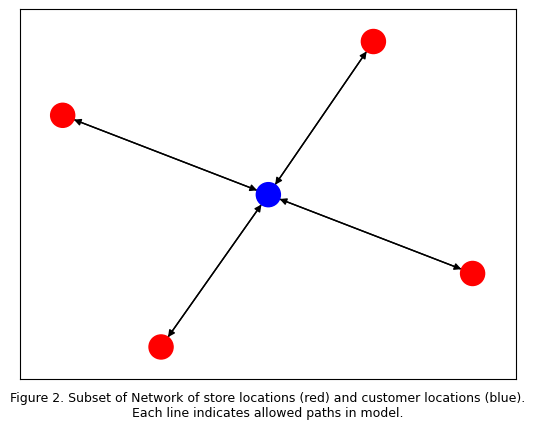

In [ ]:
subgraph = G_store_cust_more_weights.subgraph(store_sub+cust_sub)

color_map = []
for node in subgraph:
    if node in store_sub:
        color_map.append('red')
    else:
        color_map.append('blue')

pos = nx.spring_layout(subgraph)
nx.draw_networkx(subgraph,pos,with_labels=False,
                node_color=color_map)
plt.annotate('Figure 2. Subset of Network of store locations (red) and customer locations (blue).\n'+
             'Each line indicates allowed paths in model.',
             xy=(0.5,-0.1),
             xycoords='axes fraction',
             fontsize=9,
             ha='center')
#plt.savefig('sample.pdf')